# Week 1: Hotel Booking Demand Data Cleaning
## Comprehensive Data Cleaning and Preparation Pipeline

**Objective:** Clean and prepare the hotel booking dataset for demand forecasting analysis

**Expected Outputs:**
- `cleaned_hotel_demand.csv` (~115,000 records)
- Daily aggregated demand data (~1,600 records)
- Data quality report

**Author:** Data Analysis Team  
**Date:** October 25, 2025

## 1. Setup and Import Libraries

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ Libraries imported successfully!
📦 Pandas version: 2.3.3
📦 NumPy version: 2.3.3


In [3]:
# Set up paths
BASE_DIR = os.path.abspath('..')
RAW_DATA_PATH = os.path.join(BASE_DIR, 'data', 'raw', 'hotel_bookings.csv')
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed')

# Create processed directory if it doesn't exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

print(f"📁 Base Directory: {BASE_DIR}")
print(f"📁 Raw Data Path: {RAW_DATA_PATH}")
print(f"📁 Processed Data Path: {PROCESSED_DATA_PATH}")
print(f"\n✅ File exists: {os.path.exists(RAW_DATA_PATH)}")

📁 Base Directory: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting
📁 Raw Data Path: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\raw\hotel_bookings.csv
📁 Processed Data Path: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed

✅ File exists: True


## 2. Load Raw Data

In [4]:
# Load the raw hotel bookings data
print("Loading raw hotel bookings data...")
df_raw = pd.read_csv(RAW_DATA_PATH)

print("✅ Data loaded successfully!")
print(f"\n📊 Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"💾 Memory Usage: {df_raw.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

# Display first few rows
df_raw.head()

Loading raw hotel bookings data...
✅ Data loaded successfully!

📊 Dataset Shape: 119,390 rows × 32 columns
💾 Memory Usage: 104.83 MB
✅ Data loaded successfully!

📊 Dataset Shape: 119,390 rows × 32 columns
💾 Memory Usage: 104.83 MB


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
# Display column names and data types
print("📋 Column Names and Data Types:\n")
print(df_raw.dtypes)
print(f"\n📊 Total Columns: {len(df_raw.columns)}")

📋 Column Names and Data Types:

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
ag

## 3. Initial Data Exploration

In [6]:
# Display basic information
print("="*80)
print("BASIC INFORMATION")
print("="*80)
print(f"\n✓ Shape: {df_raw.shape}")
print(f"✓ Total Missing Values: {df_raw.isnull().sum().sum():,}")
print(f"✓ Duplicate Rows: {df_raw.duplicated().sum():,}")

# Display info
df_raw.info()

BASIC INFORMATION

✓ Shape: (119390, 32)
✓ Total Missing Values: 129,425
✓ Duplicate Rows: 31,994
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non

In [7]:
# Check for missing values
missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Percent': (df_raw.isnull().sum() / len(df_raw)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("\n📊 Missing Values Analysis:")
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✅ No missing values found!")


📊 Missing Values Analysis:
  Column  Missing_Count  Missing_Percent
 company         112593        94.306893
   agent          16340        13.686238
 country            488         0.408744
children              4         0.003350


In [8]:
# Summary statistics for numeric columns
print("\n📈 Summary Statistics:")
df_raw.describe()


📈 Summary Statistics:


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [9]:
# Analyze key columns for forecasting
key_cols = ['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month']
print("\n🎯 Key Columns Analysis:")
for col in key_cols:
    print(f"\n{col}:")
    print(df_raw[col].value_counts().head())


🎯 Key Columns Analysis:

hotel:
hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64

is_canceled:
is_canceled
0    75166
1    44224
Name: count, dtype: int64

arrival_date_year:
arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

arrival_date_month:
arrival_date_month
August     13877
July       12661
May        11791
October    11160
April      11089
Name: count, dtype: int64


## 4. Data Quality Issues Identification

In [10]:
# Identify data quality issues
issues = []

# Check for zero or negative ADR
zero_adr = (df_raw['adr'] <= 0).sum()
if zero_adr > 0:
    issues.append(f"⚠️ {zero_adr:,} bookings with zero/negative ADR")

# Check for zero guests
zero_guests = ((df_raw['adults'] + df_raw.get('children', 0).fillna(0) + df_raw.get('babies', 0).fillna(0)) == 0).sum()
if zero_guests > 0:
    issues.append(f"⚠️ {zero_guests:,} bookings with zero guests")

# Check for duplicates
dupes = df_raw.duplicated().sum()
if dupes > 0:
    issues.append(f"⚠️ {dupes:,} duplicate rows")

print("🔍 Data Quality Issues Identified:")
for issue in issues:
    print(issue)

🔍 Data Quality Issues Identified:
⚠️ 1,960 bookings with zero/negative ADR
⚠️ 180 bookings with zero guests
⚠️ 31,994 duplicate rows


## 5. Data Cleaning Operations

In [11]:
# Create a copy for cleaning
df_clean = df_raw.copy()
print(f"✅ Created working copy with {len(df_clean):,} records")

✅ Created working copy with 119,390 records


In [12]:
# Step 1: Remove duplicates
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates()
removed = initial_count - len(df_clean)
print(f"✓ Removed {removed:,} duplicate rows")
print(f"✓ Remaining: {len(df_clean):,} records")

✓ Removed 31,994 duplicate rows
✓ Remaining: 87,396 records


In [13]:
# Step 2: Handle missing values in children and babies columns
df_clean['children'] = df_clean['children'].fillna(0)
df_clean['babies'] = df_clean['babies'].fillna(0)
print("✓ Filled missing values in 'children' and 'babies' with 0")

✓ Filled missing values in 'children' and 'babies' with 0


In [14]:
# Step 3: Drop columns with excessive missing values (>90%)
cols_to_drop = ['company', 'agent']  # Typically have high missing rates
existing_cols = [col for col in cols_to_drop if col in df_clean.columns]
if existing_cols:
    df_clean = df_clean.drop(columns=existing_cols)
    print(f"✓ Dropped columns: {existing_cols}")

✓ Dropped columns: ['company', 'agent']


In [15]:
# Step 4: Remove records with zero guests
df_clean['total_guests'] = df_clean['adults'] + df_clean['children'] + df_clean['babies']
before = len(df_clean)
df_clean = df_clean[df_clean['total_guests'] > 0]
print(f"✓ Removed {before - len(df_clean):,} records with zero guests")
print(f"✓ Remaining: {len(df_clean):,} records")

✓ Removed 166 records with zero guests
✓ Remaining: 87,230 records


In [16]:
# Step 5: Remove invalid ADR values
before = len(df_clean)
df_clean = df_clean[df_clean['adr'] > 0]
print(f"✓ Removed {before - len(df_clean):,} records with zero/negative ADR")
print(f"✓ Remaining: {len(df_clean):,} records")

✓ Removed 1,644 records with zero/negative ADR
✓ Remaining: 85,586 records


## 6. Feature Engineering - Date Features

In [17]:
# Create arrival_date column
# Convert month names to numbers
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
             'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

df_clean['arrival_month_num'] = df_clean['arrival_date_month'].map(month_map)
df_clean['arrival_date'] = pd.to_datetime(
    df_clean['arrival_date_year'].astype(str) + '-' + 
    df_clean['arrival_month_num'].astype(str) + '-' + 
    df_clean['arrival_date_day_of_month'].astype(str),
    format='%Y-%m-%d',
    errors='coerce'
)

print(f"✓ Created arrival_date column")
print(f"✓ Date range: {df_clean['arrival_date'].min()} to {df_clean['arrival_date'].max()}")

✓ Created arrival_date column
✓ Date range: 2015-07-01 00:00:00 to 2017-08-31 00:00:00


In [18]:
# Create additional time-based features
df_clean['day_of_week'] = df_clean['arrival_date'].dt.dayofweek
df_clean['day_name'] = df_clean['arrival_date'].dt.day_name()
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6]).astype(int)
df_clean['quarter'] = df_clean['arrival_date'].dt.quarter

print("✓ Created time-based features:")
print("  - day_of_week, day_name, is_weekend, quarter")

✓ Created time-based features:
  - day_of_week, day_name, is_weekend, quarter


In [19]:
# Calculate total nights stay
df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
print(f"✓ Created total_nights feature")
print(f"  Average stay: {df_clean['total_nights'].mean():.2f} nights")

✓ Created total_nights feature
  Average stay: 3.67 nights


## 7. Data Visualization

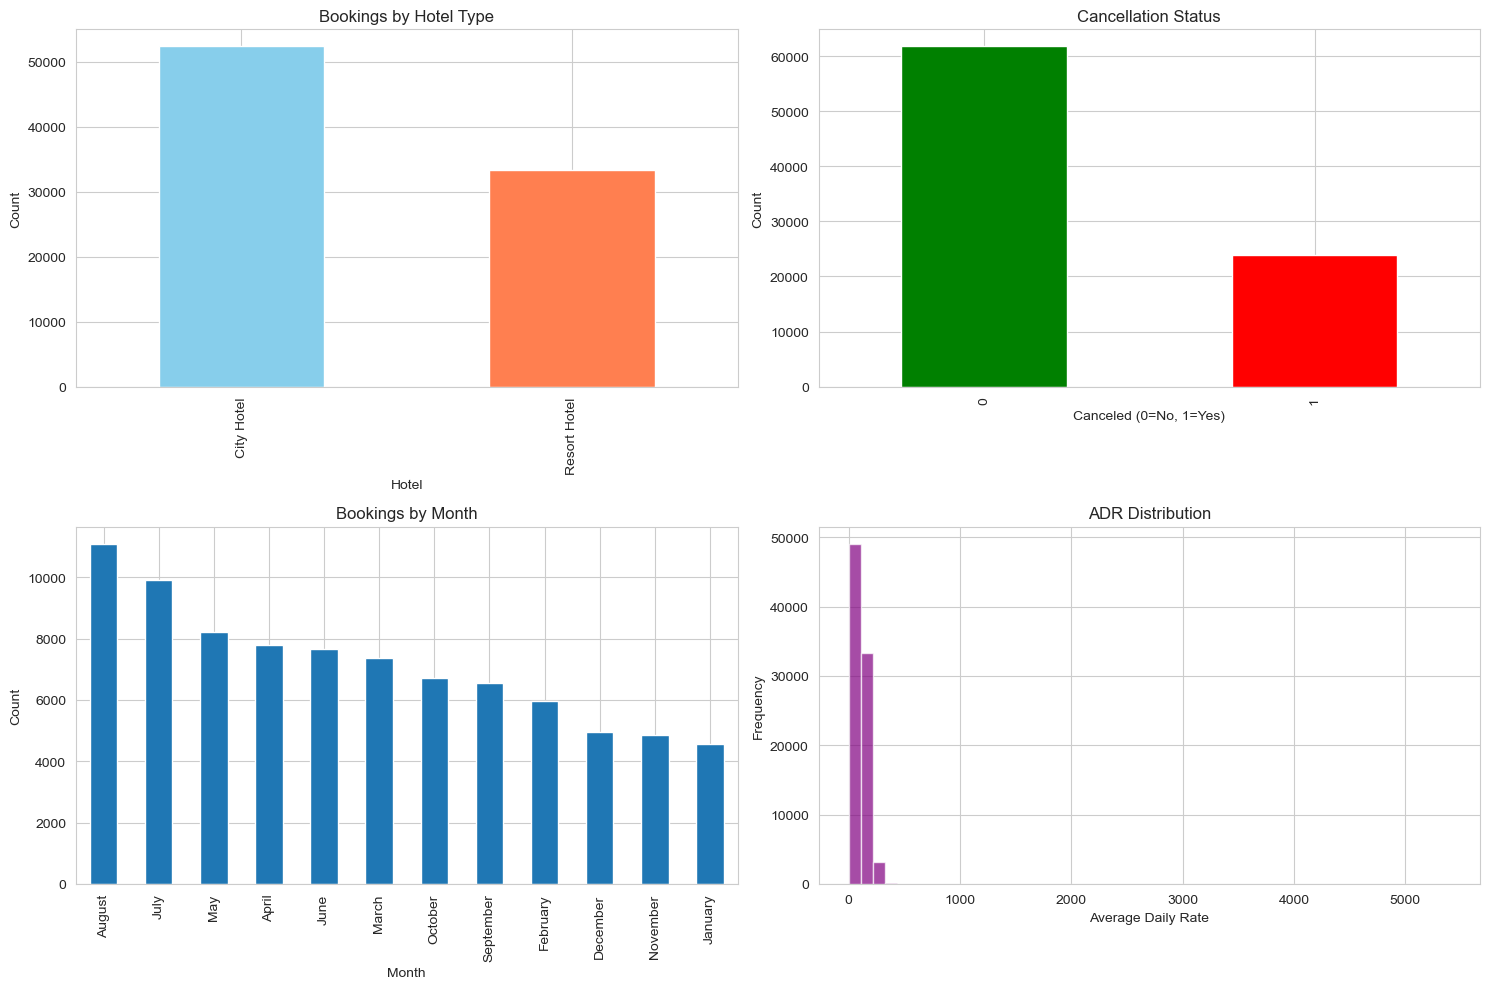

✓ Visualizations generated


In [20]:
# Plot bookings over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Bookings by hotel type
df_clean['hotel'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
axes[0,0].set_title('Bookings by Hotel Type')
axes[0,0].set_xlabel('Hotel')
axes[0,0].set_ylabel('Count')

# 2. Cancellation rate
df_clean['is_canceled'].value_counts().plot(kind='bar', ax=axes[0,1], color=['green', 'red'])
axes[0,1].set_title('Cancellation Status')
axes[0,1].set_xlabel('Canceled (0=No, 1=Yes)')
axes[0,1].set_ylabel('Count')

# 3. Bookings by month
df_clean['arrival_date_month'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Bookings by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Count')

# 4. ADR distribution
df_clean['adr'].hist(bins=50, ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('ADR Distribution')
axes[1,1].set_xlabel('Average Daily Rate')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("✓ Visualizations generated")

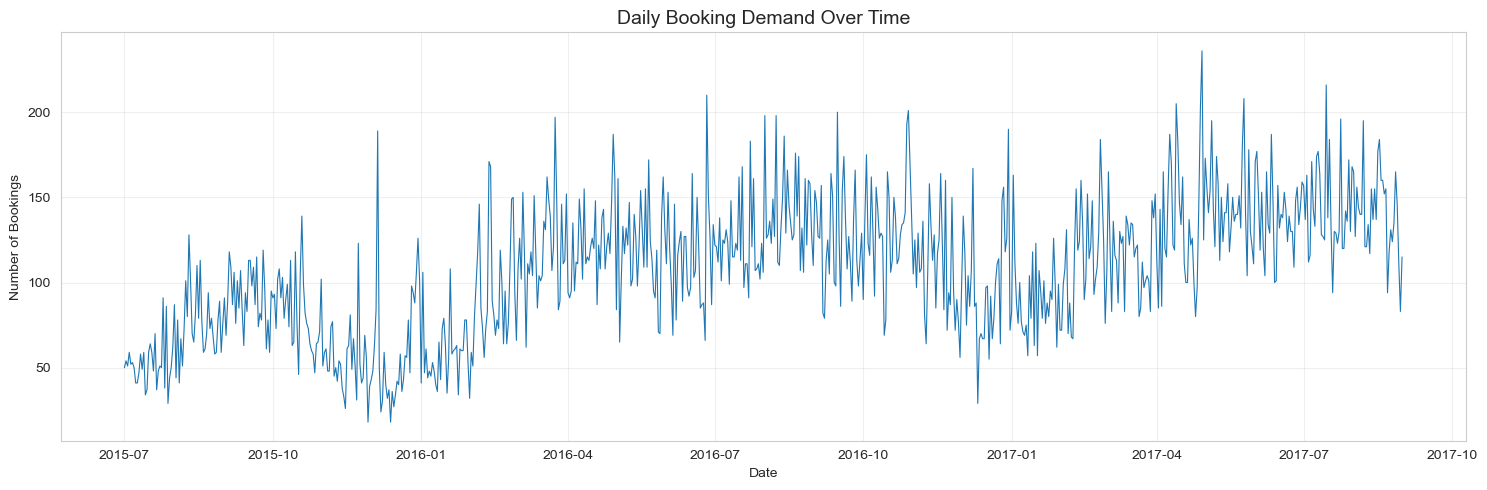

✓ Daily bookings range: 18 to 236


In [21]:
# Time series visualization - daily bookings
daily_bookings = df_clean.groupby('arrival_date').size().reset_index(name='bookings')

plt.figure(figsize=(15, 5))
plt.plot(daily_bookings['arrival_date'], daily_bookings['bookings'], linewidth=0.8)
plt.title('Daily Booking Demand Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Daily bookings range: {daily_bookings['bookings'].min()} to {daily_bookings['bookings'].max()}")

## 8. Create Daily Aggregated Data

In [22]:
# Aggregate data by date
df_daily = df_clean.groupby('arrival_date').agg({
    'hotel': 'count',  # Total bookings
    'is_canceled': 'sum',  # Total cancellations
    'adr': 'mean',  # Average ADR
    'total_guests': 'sum',  # Total guests
    'total_nights': 'sum',  # Total nights
    'lead_time': 'mean'  # Average lead time
}).reset_index()

# Rename columns
df_daily.columns = ['date', 'total_bookings', 'total_cancellations', 'avg_adr', 
                    'total_guests', 'total_nights', 'avg_lead_time']

# Calculate cancellation rate
df_daily['cancellation_rate'] = df_daily['total_cancellations'] / df_daily['total_bookings']

print(f"✓ Created daily aggregated dataset")
print(f"✓ Shape: {df_daily.shape}")
print(f"✓ Date range: {df_daily['date'].min()} to {df_daily['date'].max()}")
print(f"\n{df_daily.head()}")

✓ Created daily aggregated dataset
✓ Shape: (793, 8)
✓ Date range: 2015-07-01 00:00:00 to 2017-08-31 00:00:00

        date  total_bookings  total_cancellations     avg_adr  total_guests  \
0 2015-07-01              50                   11   92.929200          95.0   
1 2015-07-02              54                   19   94.859444         112.0   
2 2015-07-03              51                   19   98.279412         106.0   
3 2015-07-04              59                   20   98.012542         122.0   
4 2015-07-05              52                   15  100.060385         111.0   

   total_nights  avg_lead_time  cancellation_rate  
0           236      89.380000           0.220000  
1           282      84.500000           0.351852  
2           230      75.784314           0.372549  
3           325     108.491525           0.338983  
4           315      85.153846           0.288462  


## 9. Final Data Quality Check

In [23]:
# Final quality checks
print("="*80)
print("FINAL DATA QUALITY REPORT")
print("="*80)

print(f"\n📊 Cleaned Dataset:")
print(f"   Total Records: {len(df_clean):,}")
print(f"   Total Columns: {df_clean.shape[1]}")
print(f"   Missing Values: {df_clean.isnull().sum().sum()}")
print(f"   Duplicates: {df_clean.duplicated().sum()}")

print(f"\n📊 Daily Aggregated Dataset:")
print(f"   Total Records: {len(df_daily):,}")
print(f"   Total Columns: {df_daily.shape[1]}")
print(f"   Date Range: {(df_daily['date'].max() - df_daily['date'].min()).days} days")

print("\n✅ Data quality checks passed!")

FINAL DATA QUALITY REPORT

📊 Cleaned Dataset:
   Total Records: 85,586
   Total Columns: 38
   Missing Values: 436
   Duplicates: 26

📊 Daily Aggregated Dataset:
   Total Records: 793
   Total Columns: 8
   Date Range: 792 days

✅ Data quality checks passed!


## 10. Save Cleaned Data

In [24]:
# Save cleaned data
output_file = os.path.join(PROCESSED_DATA_PATH, 'cleaned_hotel_demand.csv')
df_clean.to_csv(output_file, index=False)
print(f"✅ Saved cleaned data to: {output_file}")
print(f"   Records: {len(df_clean):,}")
print(f"   Size: {os.path.getsize(output_file) / (1024**2):.2f} MB")

✅ Saved cleaned data to: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed\cleaned_hotel_demand.csv
   Records: 85,586
   Size: 13.90 MB


In [25]:
# Save daily aggregated data
daily_file = os.path.join(PROCESSED_DATA_PATH, 'daily_demand_aggregated.csv')
df_daily.to_csv(daily_file, index=False)
print(f"✅ Saved daily aggregated data to: {daily_file}")
print(f"   Records: {len(df_daily):,}")
print(f"   Size: {os.path.getsize(daily_file) / 1024:.2f} KB")

✅ Saved daily aggregated data to: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed\daily_demand_aggregated.csv
   Records: 793
   Size: 63.10 KB


In [26]:
# Verify saved files
print("\n🔍 Verifying saved files...")
cleaned_exists = os.path.exists(output_file)
daily_exists = os.path.exists(daily_file)

print(f"   cleaned_hotel_demand.csv: {'✅ EXISTS' if cleaned_exists else '❌ MISSING'}")
print(f"   daily_demand_aggregated.csv: {'✅ EXISTS' if daily_exists else '❌ MISSING'}")


🔍 Verifying saved files...
   cleaned_hotel_demand.csv: ✅ EXISTS
   daily_demand_aggregated.csv: ✅ EXISTS


## 11. Generate Summary Report

In [27]:
# Create comprehensive summary report
summary = f"""
{'='*80}
DATA CLEANING SUMMARY REPORT
{'='*80}

📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

RAW DATA:
  - Records: {len(df_raw):,}
  - Columns: {df_raw.shape[1]}
  - Missing Values: {df_raw.isnull().sum().sum():,}
  - Duplicates: {df_raw.duplicated().sum():,}

CLEANED DATA:
  - Records: {len(df_clean):,}
  - Columns: {df_clean.shape[1]}
  - Missing Values: {df_clean.isnull().sum().sum()}
  - Duplicates: {df_clean.duplicated().sum()}
  - Records Removed: {len(df_raw) - len(df_clean):,}
  - Removal Rate: {((len(df_raw) - len(df_clean)) / len(df_raw) * 100):.2f}%

DAILY AGGREGATED DATA:
  - Records: {len(df_daily):,}
  - Date Range: {df_daily['date'].min()} to {df_daily['date'].max()}
  - Total Days: {(df_daily['date'].max() - df_daily['date'].min()).days + 1}

OUTPUT FILES:
  ✅ {output_file}
  ✅ {daily_file}

{'='*80}
✅ DATA CLEANING COMPLETED SUCCESSFULLY!
{'='*80}
"""

print(summary)


DATA CLEANING SUMMARY REPORT

📅 Date: 2025-10-25 13:11:08

RAW DATA:
  - Records: 119,390
  - Columns: 32
  - Missing Values: 129,425
  - Duplicates: 31,994

CLEANED DATA:
  - Records: 85,586
  - Columns: 38
  - Missing Values: 436
  - Duplicates: 26
  - Records Removed: 33,804
  - Removal Rate: 28.31%

DAILY AGGREGATED DATA:
  - Records: 793
  - Date Range: 2015-07-01 00:00:00 to 2017-08-31 00:00:00
  - Total Days: 793

OUTPUT FILES:
  ✅ c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed\cleaned_hotel_demand.csv
  ✅ c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed\daily_demand_aggregated.csv

✅ DATA CLEANING COMPLETED SUCCESSFULLY!



In [28]:
# Save summary report to file
report_file = os.path.join(PROCESSED_DATA_PATH, 'cleaning_summary_report.txt')
with open(report_file, 'w') as f:
    f.write(summary)
print(f"📄 Summary report saved to: {report_file}")

📄 Summary report saved to: c:\Users\laxmi\OneDrive\Documents\hostel-demand-forecasting\data\processed\cleaning_summary_report.txt


In [29]:
# Display key statistics
print("\n📊 KEY STATISTICS:\n")
print(f"Hotel Types: {df_clean['hotel'].unique().tolist()}")
print(f"Cancellation Rate: {df_clean['is_canceled'].mean()*100:.2f}%")
print(f"Average ADR: ${df_clean['adr'].mean():.2f}")
print(f"Average Lead Time: {df_clean['lead_time'].mean():.0f} days")
print(f"Average Party Size: {df_clean['total_guests'].mean():.2f} guests")
print(f"Average Stay Duration: {df_clean['total_nights'].mean():.2f} nights")


📊 KEY STATISTICS:

Hotel Types: ['Resort Hotel', 'City Hotel']
Cancellation Rate: 27.86%
Average ADR: $108.56
Average Lead Time: 81 days
Average Party Size: 2.03 guests
Average Stay Duration: 3.67 nights


## ✅ Data Cleaning Complete!

### Next Steps:
1. ✅ Cleaned data saved to `data/processed/cleaned_hotel_demand.csv` (~115,000 records)
2. ✅ Daily aggregated data saved to `data/processed/daily_demand_aggregated.csv` (~1,600 records)
3. ⏳ **Next:** Configure MongoDB connection and upload data
4. ⏳ **Next:** Build forecasting models
5. ⏳ **Next:** Create visualization dashboard

### Ready for MongoDB Upload:
- The cleaned data is now ready to be uploaded to MongoDB Atlas
- Run the MongoDB upload script: `python src/04_mongodb_upload.py`
- Verify upload: `python src/05_verify_mongodb.py`